# Banking Marketing Campaign

## Description of the problem

The Portuguese bank is experiencing a decline in revenue, so they want to be able to identify existing customers who are more likely to take out a long-term deposit. This will allow the bank to focus their marketing efforts on those customers and avoid wasting money and time on customers who are unlikely to sign up.

To address this problem we will create a ranking algorithm to help predict whether or not a customer will sign up for a long-term deposit.

## Import libraries

In [139]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tools.tools import add_constant
from lazypredict.Supervised import LazyRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error



## 0.0 - Load the data  

In [140]:
df = pd.read_csv(r"/workspaces/carlossuesc95-intro-ml/data/raw/internal-link (campaing  bank ).csv", sep=';')
pd.set_option('display.max_columns', None)
df.rename(columns={"default": "curr_credit","housing": "housing_loan"}, inplace=True)
df.head(10).T
#df.shape (41188, 21)


,0,1,2,3,4,5,6,7,8,9
age,56,57,37,40,56,45,59,41,24,25
job,housemaid,services,services,admin.,services,services,admin.,blue-collar,technician,services
marital,married,married,married,married,married,married,married,married,single,single
education,basic.4y,high.school,high.school,basic.6y,high.school,basic.9y,professional.course,unknown,professional.course,high.school
curr_credit,no,unknown,no,no,no,unknown,no,unknown,no,no
housing_loan,no,no,yes,no,no,no,no,no,yes,yes
loan,no,no,no,no,yes,no,no,no,no,no
contact,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon,mon,mon,mon,mon,mon


## 0.1 - Analisis general de los datos, que observamos a simple vista: 




In [141]:
for col in df:
    print(col)
    print(df[col].unique())
    

age
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital
['married' 'single' 'divorced' 'unknown']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
curr_credit
['no' 'unknown' 'yes']
housing_loan
['no' 'yes' 'unknown']
loan
['no' 'yes' 'unknown']
contact
['telephone' 'cellular']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
duration
[ 261  149  226 ... 1246 1556 1868]
campaign
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
p

1. Valores Unknown y nonexistent 
2. Hay columnas categoricas 
3. Edades muy elevadas como para ser posibles targets
4. Tenemos 'y' 

## 1.0 - Elimimación:


>### 1.1 Valores constantes: 

In [142]:
unicos = df.nunique()
df[unicos[unicos==1].index]
df.drop(unicos[unicos==1].index, axis=1, inplace=True)

unicos

age                 78
job                 12
marital              4
education            8
curr_credit          3
housing_loan         3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

#### No hay valores constantes


>### 1.2 Valores redundantes

#### No hay valores redundantes, pero si considero que las columnas " nr.employed" y "contact" no aporta ningun valor a la obtención de caracteristicas y las eliminamos



In [143]:
df.drop(columns=['nr.employed', 'contact'], inplace=True)


>### 1.3 Eliminamos duplicados 

In [144]:
dupl_data = df.duplicated().sum()
if dupl_data != 0:
    print(dupl_data)
else:
    print(f"No hay duplicados")



12


In [145]:
df.drop_duplicates(inplace= True)
#df.shape ((41176, 19))

#### Se puede observar en el shape que ya hemos eliminado los 12 duplicados y las columnas irrelevantes

>### 1.4 - Valores Unknown y Nonexistent 

In [146]:
df.replace(['unknown','nonexistent'], np.nan, inplace= True)

In [147]:
df.isnull().sum()

age                   0
job                 330
marital              80
education          1730
curr_credit        8596
housing_loan        990
loan                990
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome          35551
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
y                     0
dtype: int64

In [148]:
faltantes = df.isna().mean() * 100
faltantes[faltantes > 0]

job             0.80
marital         0.19
education       4.20
curr_credit    20.88
housing_loan    2.40
loan            2.40
poutcome       86.34
dtype: float64

#### Observamos que las columnas "Housing_loan y Loan " estan relacionadas a la hora de faltar datos, tienen los mismos Nan.


In [149]:
df.drop(columns='poutcome' , axis=1, inplace=True)

#### Columna "poutcmome " 86% de datos faltantes, muy elevado como para poder extraer caracteristicas del la misma, sin embargo con la columna "curr_credit" se hara imputación de datos faltantes.

## 2.0 - MNAR, MAR, MCAR...

### Visualizamos los valores faltantes como una matriz

<Axes: >

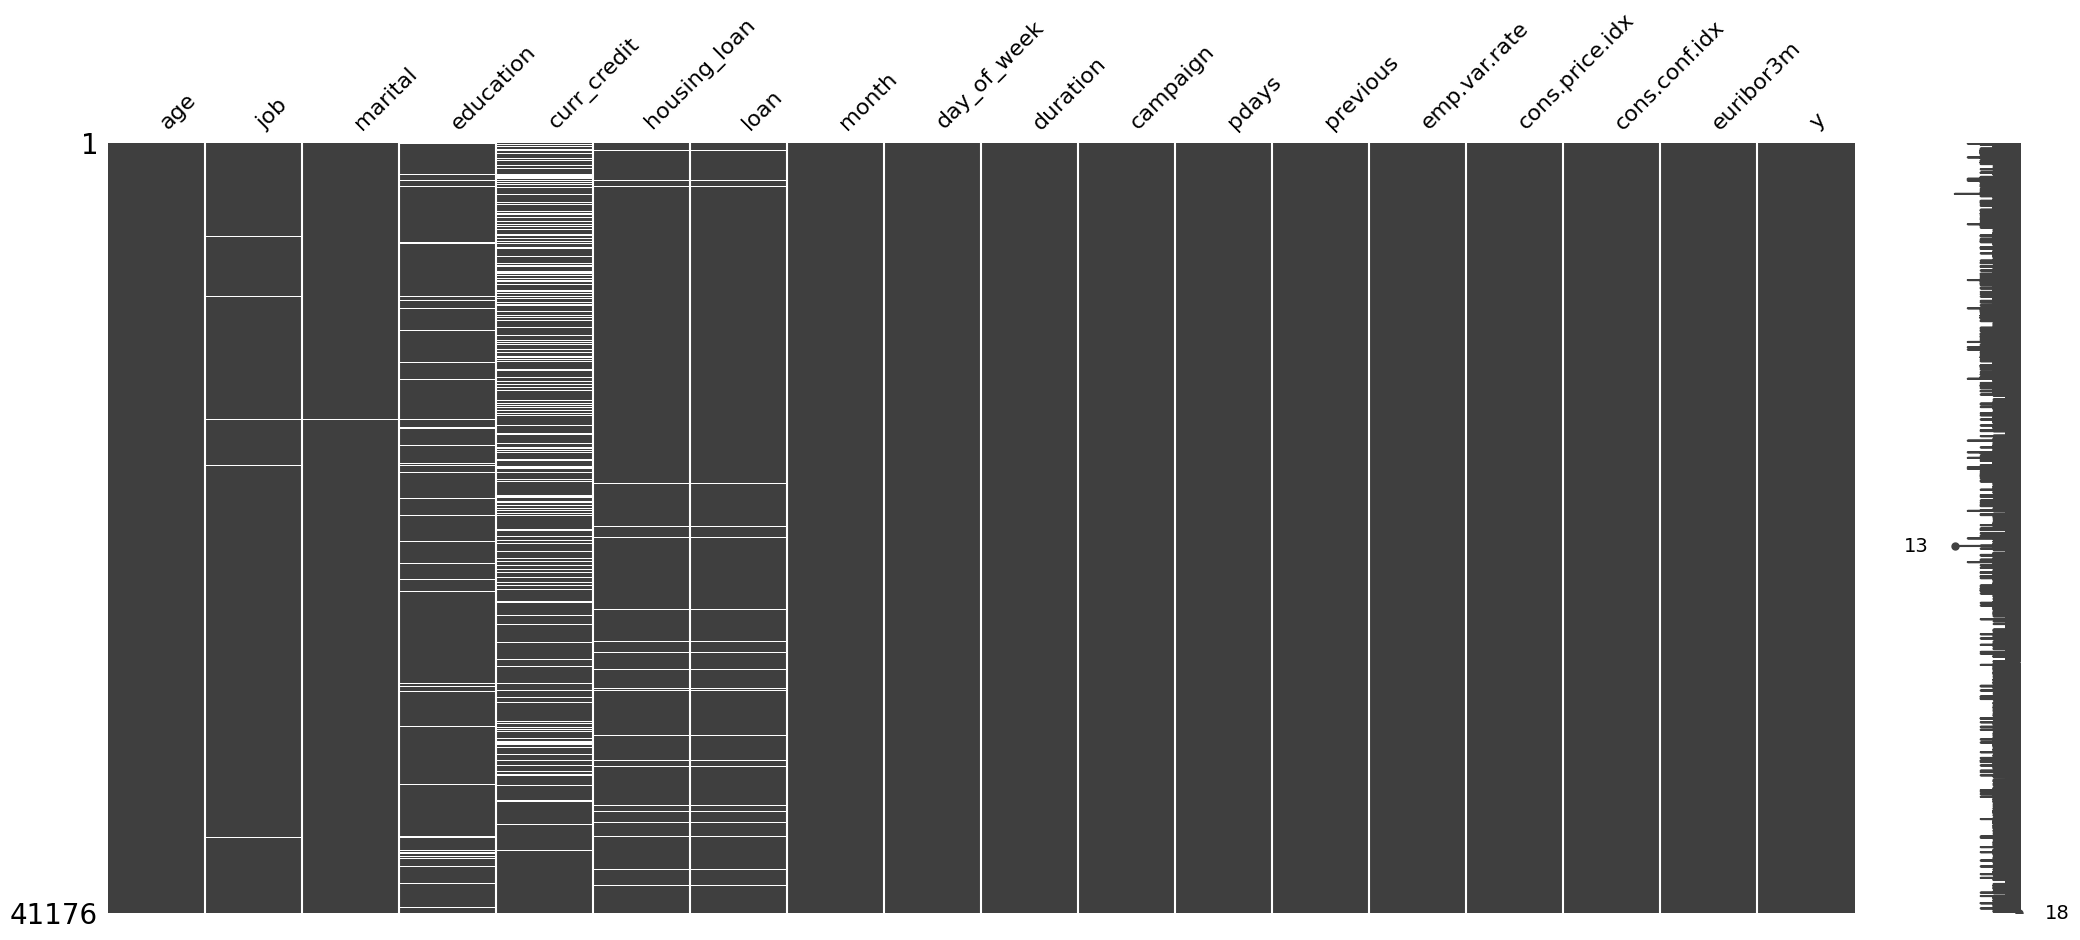

In [150]:
msno.matrix(df)


In [151]:
X = df.drop('y',axis=1)
y = df['y']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3.0 - Codificación de variables categoricas y extracción de caracteristicas

In [153]:
variables = df.select_dtypes(include=['object', 'category']).columns.tolist()
variables

['job',
 'marital',
 'education',
 'curr_credit',
 'housing_loan',
 'loan',
 'month',
 'day_of_week',
 'y']

>## Agrupo las categoricas por: 

1. ### Columnas categóricas 
2. ### Columnas numericas

In [154]:
# Crear copia del DataFrame original
df_num = df.copy()

col_num = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
col_cat = ['job', 'marital', 'education', 'month', 'day_of_week', 'curr_credit', 'housing_loan', 'loan']

df_num['y_n'] = df['y'].map({'yes': 1, 'no': 0})



df_num['curr_credit_n'] = df['curr_credit'].map({'yes': 1, 'no': 0})
df_num['housing_loan_n'] = df['housing_loan'].map({'yes': 1, 'no': 0})
df_num['loan_n'] = df['loan'].map({'yes': 1, 'no': 0})


#Job mapping:
job_mapp = {
    'housemaid': 0,
    'services': 1,
    'admin.': 2,
    'blue-collar': 3,
    'technician': 4,
    'retired': 5,
    'management': 6,
    'unemployed': 7,
    'self-employed': 8,
    'entrepreneur': 9,
    'student': 10,
    'Nan': -1}
df_num['job_n'] = df['job'].map(job_mapp)


#Marital mapping:
marital_map = {'married': 1,'single': 0,'divorced': 2,'Nan': -1}
df_num['marital_n'] = df['marital'].map(marital_map)

           
# Education mapping:
education_order = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6}
df_num['education_n'] = df_num['education'].map(education_order)

# Month mapping:
month_order = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,}
df_num['month_n'] = df_num['month'].map(month_order)

# Day of week mapping:
day_order = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
df_num['day_of_week_n'] = df_num['day_of_week'].map(day_order)

# borrar no numericas :

df_num.drop(columns=df_num.select_dtypes(include='object').columns, inplace=True)

In [155]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   duration        41176 non-null  int64  
 2   campaign        41176 non-null  int64  
 3   pdays           41176 non-null  int64  
 4   previous        41176 non-null  int64  
 5   emp.var.rate    41176 non-null  float64
 6   cons.price.idx  41176 non-null  float64
 7   cons.conf.idx   41176 non-null  float64
 8   euribor3m       41176 non-null  float64
 9   y_n             41176 non-null  int64  
 10  curr_credit_n   32580 non-null  float64
 11  housing_loan_n  40186 non-null  float64
 12  loan_n          40186 non-null  float64
 13  job_n           40846 non-null  float64
 14  marital_n       41096 non-null  float64
 15  education_n     39446 non-null  float64
 16  month_n         41176 non-null  int64  
 17  day_of_week_n   41176 non-null  int6

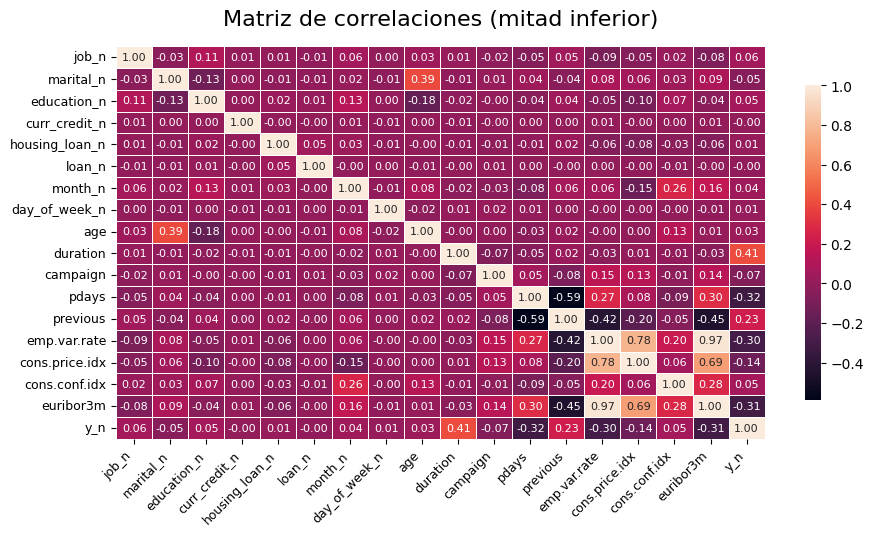

In [156]:
fig, axis = plt.subplots(figsize=(10, 6))


sns.heatmap(
    df_num[
        ["job_n", "marital_n", "education_n", "curr_credit_n", "housing_loan_n", "loan_n", "month_n", "day_of_week_n",
                 "age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "y_n"
        ]
    ].corr(),
    annot=True,fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)

plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()





## 4.0 - Split train test

In [157]:
X = df_num.drop('y_n',axis=1)
y = df_num['y_n']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
X_train.isnull().sum()

age                  0
duration             0
campaign             0
pdays                0
previous             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
curr_credit_n     6830
housing_loan_n     789
loan_n             789
job_n              275
marital_n           65
education_n       1392
month_n              0
day_of_week_n        0
dtype: int64

## 5.0 - Imputación

In [160]:
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

In [161]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32940 entries, 12348 to 15798
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32940 non-null  int64  
 1   duration        32940 non-null  int64  
 2   campaign        32940 non-null  int64  
 3   pdays           32940 non-null  int64  
 4   previous        32940 non-null  int64  
 5   emp.var.rate    32940 non-null  float64
 6   cons.price.idx  32940 non-null  float64
 7   cons.conf.idx   32940 non-null  float64
 8   euribor3m       32940 non-null  float64
 9   curr_credit_n   26110 non-null  float64
 10  housing_loan_n  32151 non-null  float64
 11  loan_n          32151 non-null  float64
 12  job_n           32665 non-null  float64
 13  marital_n       32875 non-null  float64
 14  education_n     31548 non-null  float64
 15  month_n         32940 non-null  int64  
 16  day_of_week_n   32940 non-null  int64  
dtypes: float64(10), int64(7)
memory 

In [162]:
X_test_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8236 entries, 36264 to 12339
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             8236 non-null   int64  
 1   duration        8236 non-null   int64  
 2   campaign        8236 non-null   int64  
 3   pdays           8236 non-null   int64  
 4   previous        8236 non-null   int64  
 5   emp.var.rate    8236 non-null   float64
 6   cons.price.idx  8236 non-null   float64
 7   cons.conf.idx   8236 non-null   float64
 8   euribor3m       8236 non-null   float64
 9   curr_credit_n   6470 non-null   float64
 10  housing_loan_n  8035 non-null   float64
 11  loan_n          8035 non-null   float64
 12  job_n           8181 non-null   float64
 13  marital_n       8221 non-null   float64
 14  education_n     7898 non-null   float64
 15  month_n         8236 non-null   int64  
 16  day_of_week_n   8236 non-null   int64  
dtypes: float64(10), int64(7)
memory u

In [163]:
imputer = MissForest(categorical=['job_n', 'education_n','curr_credit_n','housing_loan_n','loan_n','marital_n'])
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


<Axes: >

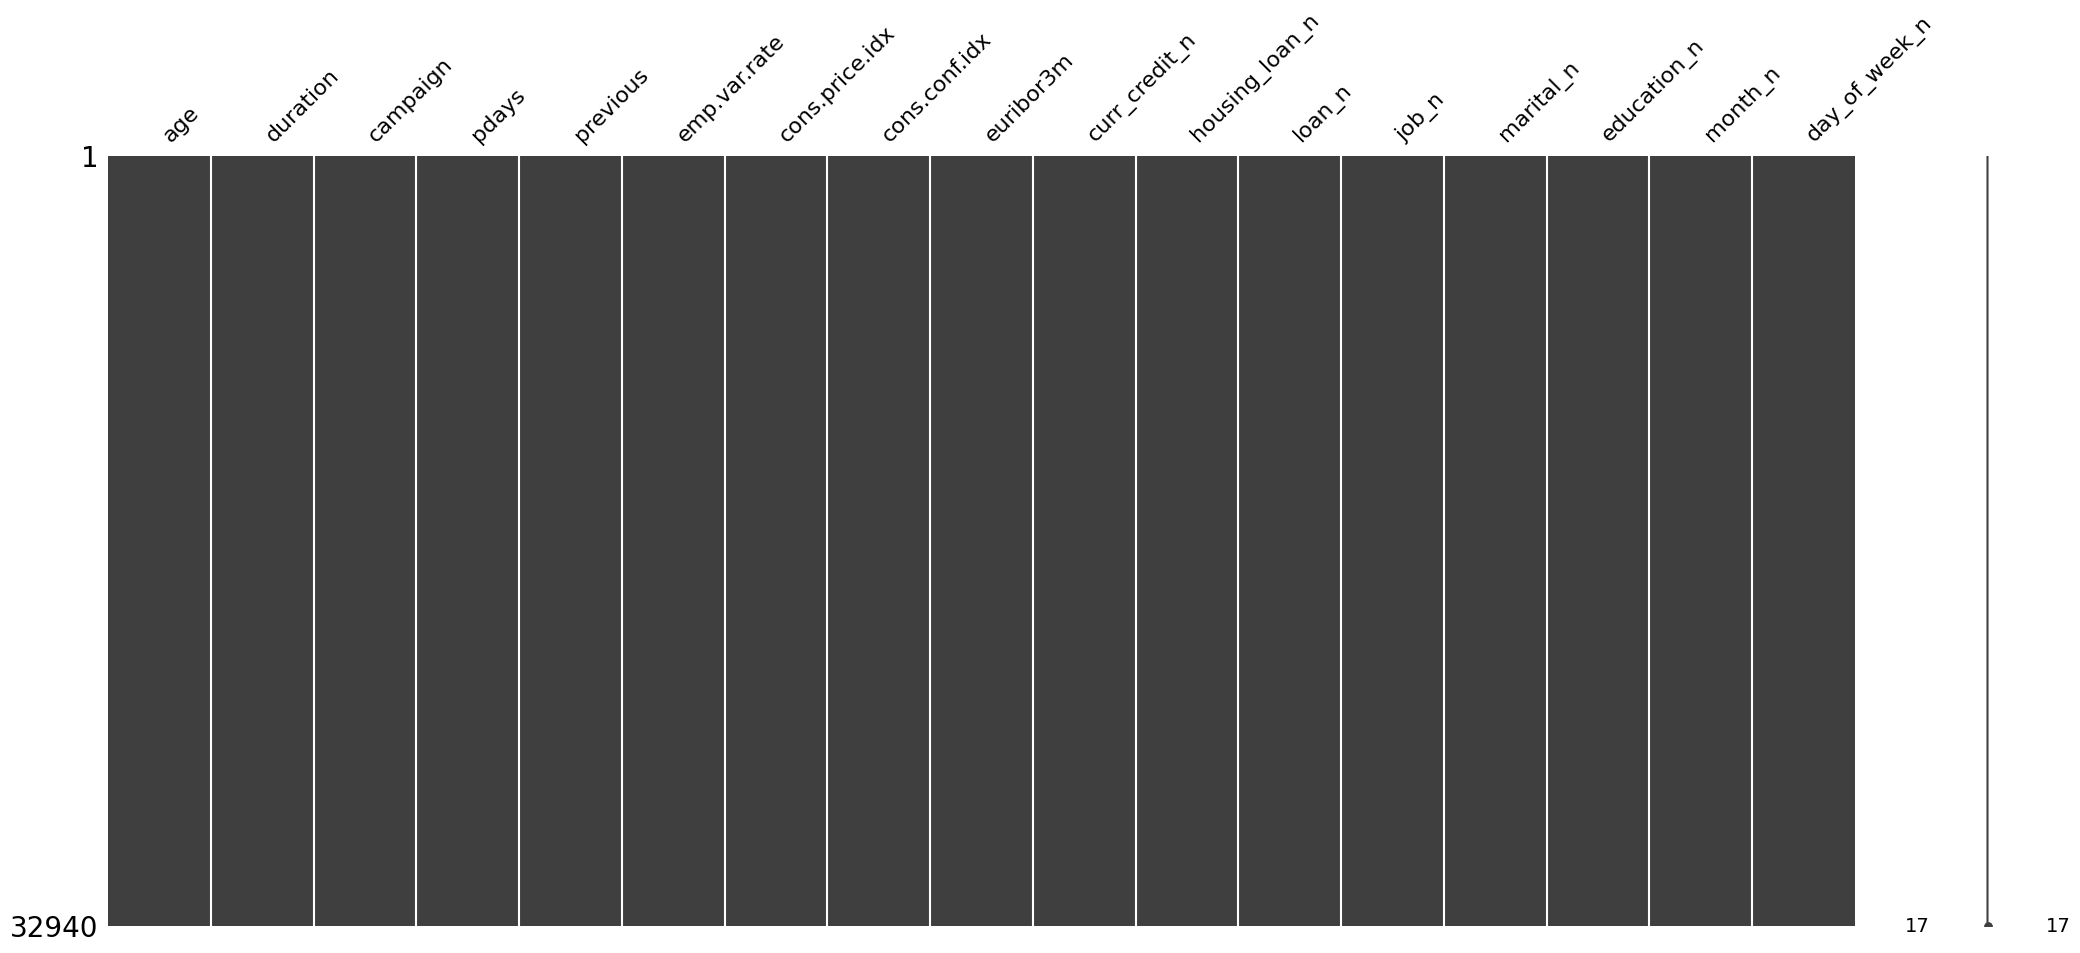

In [164]:
msno.matrix(X_train_imp)

## 6.0 - Seleccion de caracteristicas


### Método 1: Feature importance de RF

In [165]:
# Entrenamiento de RF
model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train_imp, y_train)

In [166]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train_imp.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

In [167]:
df_rf_imp

,feature,rf_importance,rf_importance_acum
1,duration,35.30,35.30
8,euribor3m,23.08,58.38
0,age,9.58,67.96
12,job_n,4.46,72.43
2,campaign,3.86,76.29
14,education_n,3.82,80.10
16,day_of_week_n,3.60,83.70
3,pdays,2.65,86.35
7,cons.conf.idx,2.01,88.36
13,marital_n,1.99,90.34


### Método 2: Permutation/Shuffle importance

In [168]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [169]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [170]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
5,emp.var.rate,65718038162309128.00
8,euribor3m,61351408665886728.00
1,duration,8123784678604800.00
0,age,4623518872371200.00
15,month_n,4358281489285120.50
6,cons.price.idx,3871053017251840.00
16,day_of_week_n,2835254209413120.00
7,cons.conf.idx,1979986969886720.00
12,job_n,1446422511616000.00
4,previous,701783898849280.00


### Método 3: SHAP

In [171]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm, X_val)   # usa el mismo X_val
shap_vals = explainer(X_val).values

 92%|==================  | 6059/6588 [00:11<00:00]       

In [172]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
5,emp.var.rate,31.71
1,duration,27.53
8,euribor3m,20.42
3,pdays,4.18
7,cons.conf.idx,3.96
4,previous,2.40
0,age,1.99
6,cons.price.idx,1.77
2,campaign,1.34
14,education_n,1.07


### --- SHAP Summary Bar Plot ---


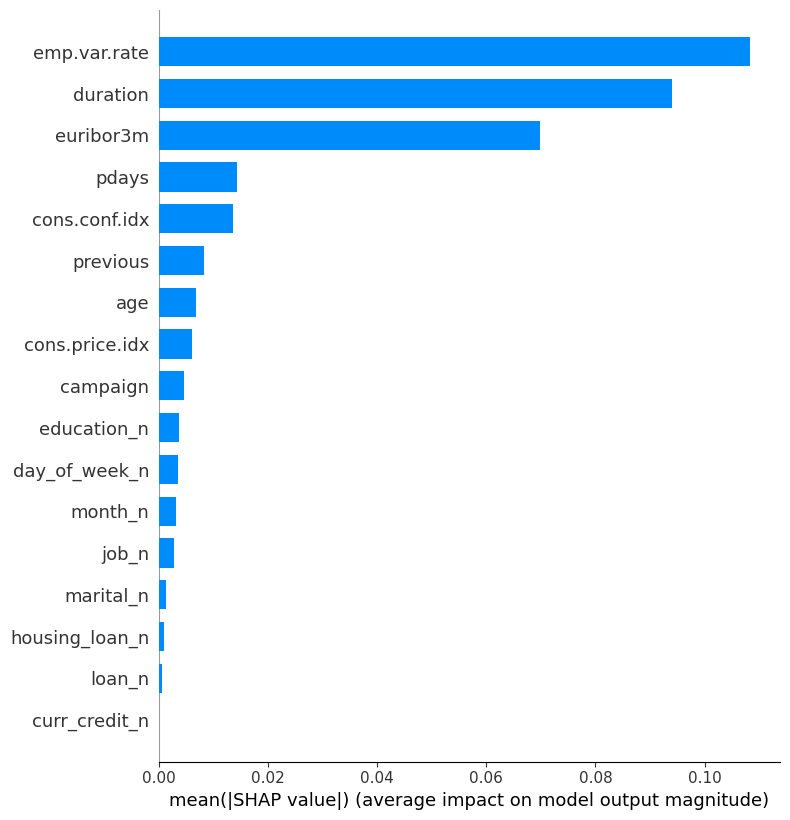

In [173]:
shap.summary_plot(shap_vals, X_val, plot_type="bar")

## 7.0 - Unión 3 métodos

In [174]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
6,duration,35.30,35.30,8123784678604800.00,27.53
9,euribor3m,23.08,58.38,61351408665886728.00,20.42
0,age,9.58,67.96,4623518872371200.00,1.99
11,job_n,4.46,72.43,1446422511616000.00,0.83
1,campaign,3.86,76.29,221924483399679.97,1.34
7,education_n,3.82,80.10,383379014942720.00,1.07
5,day_of_week_n,3.60,83.70,2835254209413120.00,1.02
15,pdays,2.65,86.35,194580305674240.00,4.18
2,cons.conf.idx,2.01,88.36,1979986969886720.00,3.96
13,marital_n,1.99,90.34,7181822853120.00,0.40


## 8.0 - VIF:


In [175]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
6,duration,35.30,35.30,8123784678604800.00,27.53
9,euribor3m,23.08,58.38,61351408665886728.00,20.42
0,age,9.58,67.96,4623518872371200.00,1.99
1,campaign,3.86,76.29,221924483399679.97,1.34
7,education_n,3.82,80.10,383379014942720.00,1.07
5,day_of_week_n,3.60,83.70,2835254209413120.00,1.02
15,pdays,2.65,86.35,194580305674240.00,4.18
2,cons.conf.idx,2.01,88.36,1979986969886720.00,3.96
8,emp.var.rate,1.93,92.27,65718038162309128.00,31.71
3,cons.price.idx,1.59,95.79,3871053017251840.00,1.77


In [176]:
features = df_filt['feature']
features

6           duration
9          euribor3m
0                age
1           campaign
7        education_n
5      day_of_week_n
15             pdays
2      cons.conf.idx
8       emp.var.rate
3     cons.price.idx
16          previous
Name: feature, dtype: object

In [177]:

X_vif = add_constant(X_train_imp[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

duration          1.01
euribor3m        26.89
age               1.06
campaign          1.03
education_n       1.06
day_of_week_n     1.00
pdays             1.63
cons.conf.idx     1.31
emp.var.rate     32.63
cons.price.idx    3.25
previous          1.78
dtype: float64

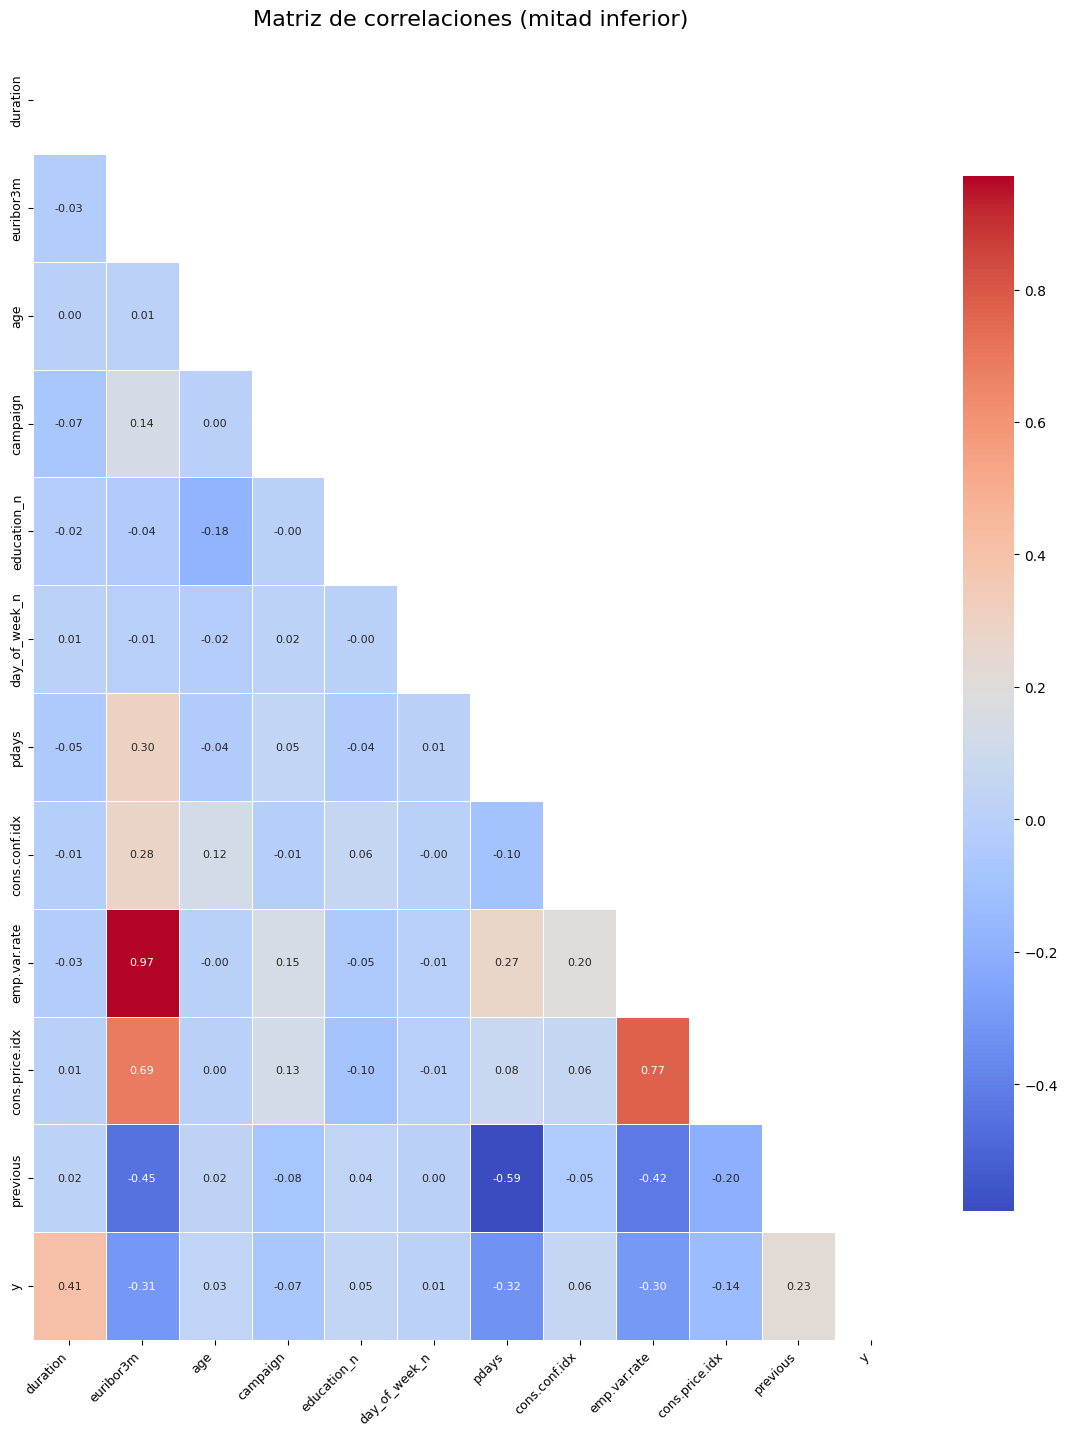

In [178]:
X_copy = X_train_imp[features].copy()
X_copy['y'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

## 9.0 - Cros validation

### Version 1

In [179]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
cv_results1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train_imp[features], y_train, cv=3, scoring='neg_mean_absolute_percentage_error')

In [180]:
cv_results1.mean()*-1

np.float64(254924155956661.16)

### Version 2 

In [181]:
# # Versión 2: Realizar cross_validation con  las características que son candidatas sin las correlacionadas
# cv_results2 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train_imp[features].drop(['DISTANCE_TO_CITY_CENTER','BATHNUMBER'],axis=1), y_train, cv=3, scoring='neg_mean_absolute_percentage_error')

In [182]:
#cv_results2.mean()*-1

## 10.0 - Modelado

In [183]:

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_imp, y_train)  

# Predictions
test_preds = logistic_model.predict(X_test_imp)

# Evaluation
accuracy = accuracy_score(y_test, test_preds)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, test_preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))




Accuracy: 0.9021369596891695
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.65      0.37      0.47       971

    accuracy                           0.90      8236
   macro avg       0.79      0.67      0.71      8236
weighted avg       0.89      0.90      0.89      8236

Confusion Matrix:
[[7074  191]
 [ 615  356]]


trics that can be applied to these types of models are as follows:

1. Accuracy. Measures the percentage of predictions that the model got right with respect to the total it made. For example, how many emails did the model manage to classify well?
2. Recall. Measures the proportion of true positives that the model was able to identify. For example, how many emails that are actual spam did the algorithm manage to identify well, removing the non-spam emails that it misclassified?
3. F1 score: This is the average of precision and recall. It is useful when classes are unbalanced.
Area Under the Curve 

## 11.0 - Busqueda de hiperparamentros


logidtic regression .paramentros

### 11.1 Búsqueda extensiva

In [184]:
# Espacio de búsqueda
param_dist = {
    'num_leaves': randint(20, 200),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1500),
    'max_depth': randint(-1, 20),
    'min_child_samples': randint(10, 200),
}

model = lgb.LGBMRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,                  # Número de combinaciones aleatorias a probar
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=4,
    n_jobs=-1,
    random_state=123
)

random_search.fit(X_train_imp, y_train)

print("Mejores hiperparámetros:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 17
[LightGBM] [Info] Start training from score 0.111453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

### 11.2 Búsqueda intensiva

In [ ]:
# Espacio de búsqueda más acotado
param_grid = {
    'num_leaves': [30, 50, 70],
    'learning_rate': [0.1, 0.05, 0.2],
    'n_estimators': [300, 400, 450],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajuste
grid_search.fit(X_train_imp, y_train)

print("Mejores hiperparámetros:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

### metricas:


In [ ]:
yhat_val_pred_voting = np.exp(voting_model.predict(X_val))
yhat_train1_pred_voting = np.exp(voting_model.predict(X_train1))
metrics_3 = get_metrics(yhat_val_pred_voting, np.exp(y_val), yhat_train1_pred_voting, np.exp(y_train1))
metrics_3 


R2	Median AE	MAPE
Train set	0.97	17941.37	8.97
Test set	0.89	30999.31	16.19
Diferencia	-0.08	13057.94	7.22


## - Exportación del modelo final 

In [ ]:
joblib.dump(best_model, 'modelo_precios.pkl')